# Produce an example plot of horizontal plasma motion over the northern magnetic pole using DMSP.

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

import pysat
import pysatMadrigal as pysat_mad

import warnings
warnings.filterwarnings("ignore", message="'S' is deprecated and will be removed in a future version, please use 's' instead.")

In [2]:
# Set data directory if user hasn't already set one
print(f"old: {pysat.params['data_dirs']}")
if len(pysat.params['data_dirs']) == 0 or pysat.params['data_dirs'] == ['.']:
    # Set a directory for pysat to use for data
    pysat.params['data_dirs'] = '/home/jovyan/scratch_space/.pysat/'
else:
    print('pysat directory has been set previously. Leaving unchanged.')

print(f"new: {pysat.params['data_dirs']}")

old: ['/home/jovyan/scratch_space/.pysat']
pysat directory has been set previously. Leaving unchanged.
new: ['/home/jovyan/scratch_space/.pysat']


In [3]:
# Register instruments in pysatMadrigal with pysat. Only needed
# once per installation.
pysat.utils.registry.register_by_module(pysat_mad.instruments)

pysat WARNING: `inst_id` did not supply KINDAT, all will be returned.
pysat WARNING: `inst_id` did not supply KINDAT, all will be returned.
pysat WARNING: `inst_id` did not supply KINDAT, all will be returned.


In [4]:
# Select Ion Velocity Meter data from the Defense Meteorological Satellite Program (DMSP)
fdate = dt.datetime(2011, 8, 15)
ivm = pysat.Instrument('dmsp', 'ivm', tag='utd', inst_id='f15')

In [5]:
# Learn about DMSP.
help(ivm.inst_module)

Help on module pysatMadrigal.instruments.dmsp_ivm in pysatMadrigal.instruments:

NAME
    pysatMadrigal.instruments.dmsp_ivm - Supports the Defense Meteorological Satellite Program (DMSP) IVM instruments.

DESCRIPTION
    The Ion Velocity Meter (IVM) is comprised of the Retarding Potential Analyzer
    (RPA) and Drift Meter (DM). The RPA measures the energy of plasma along the
    direction of satellite motion. By fitting these measurements to a theoretical
    description of plasma the number density, plasma composition, plasma
    temperature, and plasma motion may be determined. The DM directly measures the
    arrival angle of plasma. Using the reported motion of the satellite the angle is
    converted into ion motion along two orthogonal directions, perpendicular to the
    satellite track. The IVM is part of the Special Sensor for Ions, Electrons, and
    Scintillations (SSIES) instrument suite on DMSP.
    
    Downloads data from the National Science Foundation Madrigal Databa

## DMSP IVM loaded data needs additional parameters to make plots over the magnetic pole. This section modifies DMSP data to enable the desired plots.

In [6]:
# Define function to select northern hemisphere locations.
def sel_hemisphere(inst, hemi='north'):
    """Downselect data to particular hemisphere.
    
    Parmeters
    ---------
    inst : pysat.Instrument
        DMSP Instrument object
    hemi : str
        'north' or 'south' for northern/southern hemisphere
        
    """
    
    if hemi == 'north':
        idx, = np.where(inst['mlat'] >= 0)
    elif hemi == 'south':
        idx, = np.where(inst['mlat'] <= 0)
    else:
        raise ValueError('Unrecognized input.')
        
    inst.data = inst[idx]
    
    return


# Attach a variety of custom functions to the `ivm` Instrument object.

# Select northern hemisphere data.
ivm.custom_attach(sel_hemisphere, kwargs={'hemi': 'north'})

# Smooth ion drifts to only report the most robust of measurements.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.smooth_ram_drifts,
                  kwargs={'rpa_flag_key': 'rpa_flag_ut'})

# Add unit vectors relating presumed satellite orientation along
# cartesian and polar directions.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.add_drift_unit_vectors)

# Express ion drifts measured in the satellite frame along the added
# high latitude unit vectors.
ivm.custom_attach(pysat_mad.instruments.methods.dmsp.add_drifts_polar_cap_x_y,
                  kwargs={'rpa_flag_key': 'rpa_flag_ut'})

In [7]:
# Download data if not already on system.
if fdate not in ivm.files.files.index:
    print('downloading new files')
    ivm.download(fdate, user='first+lastname', password='myname@email.address')

In [8]:
# Load data and apply all custom functions.
ivm.load(date=fdate)

In [9]:
# Learn about DMSP Instrument object.
print(ivm)

pysat Instrument object
-----------------------
Platform: 'dmsp'
Name: 'ivm'
Tag: 'utd'
Instrument id: 'f15'

Data Processing
---------------
Cleaning Level: 'clean'
Data Padding: None
Custom Functions: 4 applied
    0: <function sel_hemisphere at 0x7f00482c5c60>
     : Kwargs={'hemi': 'north'}
    1: <function smooth_ram_drifts at 0x7eff890883a0>
     : Kwargs={'rpa_flag_key': 'rpa_flag_ut'}
    2: <function add_drift_unit_vectors at 0x7eff890884c0>
    3: <function add_drifts_polar_cap_x_y at 0x7eff89088550>
     : Kwargs={'rpa_flag_key': 'rpa_flag_ut'}

Local File Statistics
---------------------
Number of files: 3
Date Range: 14 August 2011 --- 16 August 2011

Loaded Data Statistics
----------------------
Date: 15 August 2011
DOY: 227
Time range: 15 August 2011 00:57:51 --- 15 August 2011 23:33:59
Number of Times: 2922
Number of variables: 41

Variable Names:
year         month        day          
                  ...                  
ion_vel_pc_x ion_vel_pc_y partial      

pys

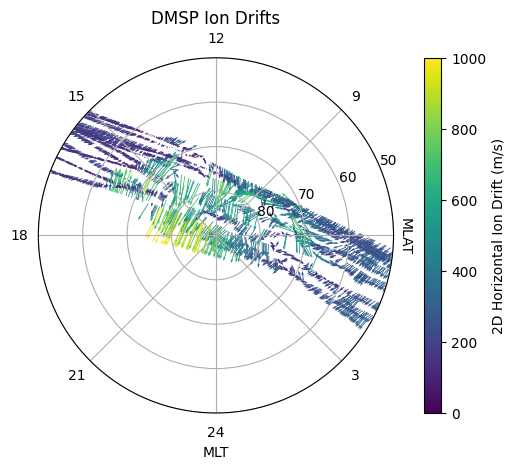

In [10]:
# Plot multiple orbital passes across polar cap.
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.set_rlim(0, 40.)
ax.set_xticks(np.linspace(0, 2. * np.pi - np.pi / 4., 8))
ax.set_xticklabels(['', 9, 12, 15, 18, 21, 24, 3])
ax.set_xlabel('MLT')
ax.set_yticks([10, 20, 30, 40])
ax.set_yticklabels([80, 70, 60, 50])
ax.text(np.deg2rad(-5.), 41, 'MLAT', rotation=-90.)
ax.grid(True)

# Location of spacecraft in relative polar coords for plotting.
theta = ivm['mlt'] * (np.pi / 12.) - np.pi / 2.
radius = 90. - np.abs(ivm['mlat'])

# Calculate magnitude of ion drifts for color values.
mag = np.sqrt(ivm['ion_vel_pc_x']**2 + ivm['ion_vel_pc_y']**2)

# Make plot of ion drifts.
slice_x = ma.masked_where(np.isnan(ivm['ion_vel_pc_x']), ivm['ion_vel_pc_x'])
slice_y = ma.masked_where(np.isnan(ivm['ion_vel_pc_y']), ivm['ion_vel_pc_y'])
vec_plot = ax.quiver(theta, radius, slice_x, slice_y, mag, scale=10000,
                    clim=[0, 1000.])

# Plot drifts without both an RPA and DM measurement in red.
ipartial, = np.where(ivm['partial'])
ax.quiver(theta[ipartial], radius[ipartial], slice_x[ipartial], slice_y[ipartial], color='r',
          scale=10000)

# Title, colorbar, and save.
plt.title('DMSP Ion Drifts')
label = ''.join(['(', ivm.meta['ion_vel_pc_x', ivm.meta.labels.units], ')'])
label = ''.join(['2D Horizontal Ion Drift ', label])
plt.colorbar(vec_plot, label=label)
plt.tight_layout()
plt.savefig('ex_dmsp_methods.png')